# Open this nodebook in colab (required):

<a target="_blank" href="https://colab.research.google.com/github/rvss-australia/RVSS/blob/main/Robotic_Vision/gaussian_blobs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Then, change the runtime type to enable gpu (required):

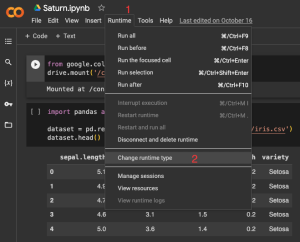

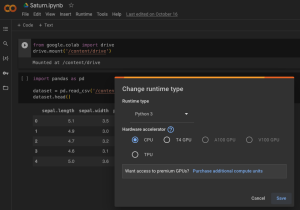

# Importing needed libraries

In [ ]:
import gdown
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from jax import grad, jit
import optax

# Defining constants

In [ ]:
TARGET_IMAGE_PATH = 'sunset_128.jpg'

NBLOBS = 16           # number of Gaussians to use
MAX_ITERS = 10000     # run optimiser max this long
OUTPUT_PERIOD = 20    # how often to update display
LEARNING_RATE = 1e-1  # optimiser gradient step length

np.random.seed(42)

# Download image

In [ ]:
file_id = "14_rEgvtxbqjGAgko9Etn3lTza59CZ2Vw"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, TARGET_IMAGE_PATH, quiet=False)

# Function to generate a Gaussian blob. Anisotropic but axis-aligned only, i.e. no rotation

In [ ]:
def gaussian_blob(center, size_x, size_y, opacity, color, x, y):
    dx = (x - center[0]) / size_x
    dy = (y - center[1]) / size_y
    return opacity * jnp.exp(-(dx**2 + dy**2) / 2)[:, :, None] * color

# Function to generate the image from blobs

In [ ]:
def generate_image(blob_params, height, width):
    x_grid, y_grid = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
    image = jnp.zeros((height, width, 3))
    for blob in blob_params:
        gaussian = gaussian_blob(
            center=blob[0:2],
            size_x=blob[2],
            size_y=blob[3],
            opacity=blob[4],
            color=blob[5:8],
            x=x_grid,
            y=y_grid,
        )
        image += gaussian
    return jnp.clip(image, 0.0, 1.0)

# Loss function: Mean Squared Error

In [ ]:
@jit
def loss_function(blob_params, target_image):
    generated_image = generate_image(blob_params, target_image.shape[0], target_image.shape[1])
    return jnp.mean((generated_image - target_image) ** 2)

# Initialize random blob parameters

In [ ]:
def init_blobs(NBLOBS, height, width):
    blobs = []
    for _ in range(NBLOBS):
        center = np.random.uniform(0, width), np.random.uniform(0, height)
        size_x = np.random.uniform(5, 10)
        size_y = np.random.uniform(5, 10)
        opacity = np.random.uniform(0.2, 0.5)
        color = np.random.uniform(-1, 1, size=3)
        blobs.append(jnp.array([*center, size_x, size_y, opacity, *color]))
    return jnp.stack(blobs)

# Load the target image

In [ ]:
target_image = imageio.imread(TARGET_IMAGE_PATH) / 255.0  # Normalize to [0, 1]
target_image = jnp.array(target_image)  # Convert to JAX array
height, width = target_image.shape[:2]  # Image dimensions

# Initialize blobs and optimizer

In [ ]:
blob_params = init_blobs(NBLOBS, height, width)
optimizer = optax.adam(learning_rate=LEARNING_RATE)
opt_state = optimizer.init(blob_params)

# Training loop

In [ ]:
for step in range(MAX_ITERS):
    grads = grad(loss_function)(blob_params, target_image)
    updates, opt_state = optimizer.update(grads, opt_state)
    blob_params = optax.apply_updates(blob_params, updates)

    if step % OUTPUT_PERIOD == 0:
        loss_val = loss_function(blob_params, target_image)
        print(f"\tStep {step}, Loss: {loss_val:.6f}")
        generated_image = generate_image(blob_params, height, width)
        plt.clf()
        plt.imshow(np.array(generated_image))
        plt.draw()
        plt.pause(0.00001)
print("Optimization finished!")

In [ ]:
generated_image = generate_image(blob_params, height, width)
plt.clf()
plt.imshow(np.array(generated_image))
plt.show()